In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import os
import time
from abc import ABC, abstractmethod
from dataclasses import dataclass

# --- ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ---
@dataclass
class TrainingParams:
    n_epochs: int
    n_train_points: int
    batch_size: int
    optimizer: any
    use_static_training_set: bool = False
    lambda_r: float = 1.0
    lambda_bc: float = None  
    lambda_ic: float = None
    grad_norm_weighting_freq :int = 25    # Частота обновления (в шагах градиентного спуска) скоростей обучения lambda.
                                          # Если частота 0, то схема взвешивания скоростей обучения не используется 
                                          # и лямбды не обновляются
                                          # Используется при обновлении лямбд: 
                                          # lambda_new = alpha * lambda_old + (1 − alpha) * lambda_new
    grad_norm_weighting_alpha: float = 0.9

class FormattedTable:
    def __init__(self, columns_settings, delimiter=" | ", n_max_rows=None):
        self.columns = [col[0] for col in columns_settings]
        self.widths =  [col[1] for col in columns_settings]
        self.formats = [col[2] for col in columns_settings]

        #self.columns_settings = columns_settings
        self.delimiter = delimiter
        self.n_max_rows = n_max_rows
        self.n_rows = 0

        if n_max_rows is None:
            self.data = {col: np.array([], dtype=object) for col in self.columns}
        else:
            self.data = {col: np.zeros(n_max_rows, dtype=object) for col in self.columns}

    def add_row(self, row):
        if len(row) != len(self.columns):
            raise ValueError("Row length must match the number of columns.")
        if  not(self.n_max_rows is None) and self.n_rows >= self.n_max_rows:
            raise ValueError("Maximum number of rows exceeded.")

        for col, value in zip(self.columns, row):
            if self.n_max_rows is None:
                self.data[col] = np.append(self.data[col], value)
            else:
                self.data[col][self.n_rows] = value
        
        self.n_rows += 1

    def table_as_string(self):
        res = [self._header_as_string()]
        for i in range(self.n_rows):
            res.append(self.delimiter.join(self._format_row(i)))
        return "\n".join(res)

    def head_as_string(self, n=0):
        res = [self._header_as_string()]
        for i in range(min(n, self.n_rows)):
            res.append(self.delimiter.join(self._format_row(i)))
        return "\n".join(res)

    def last_row_as_string(self):
        if self.n_rows > 0:
            return self.delimiter.join(self._format_row(self.n_rows - 1))

    def _header_as_string(self):
        header = [name.rjust(width) for name, width in zip(self.columns, self.widths)]
        res = self.delimiter.join(header) + '\n'
        res += self.delimiter.join('-' * width for width in self.widths)
        return res

    def _format_row(self, index):
        return [
            f"{{:{width}{fmt}}}".format(self.data[col][index])
            for col, fmt, width in zip(self.columns, self.formats, self.widths)
        ]

def initialize_weights(model, scheme):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if scheme == 'naive':
                nn.init.normal_(layer.weight, mean=0.0, std=1.0)
                if layer.bias is not None:
                    nn.init.normal_(layer.weight, mean=0.0, std=1.0)
            elif scheme == 'glorot_uniform':
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif scheme == 'glorot_normal':
                nn.init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            else:
                raise ValueError(f"{scheme} is an unknown scheme for weights initialization")

def sample_points_1D(bounds: list[float], n: int, scheme: str, sobol_engine: torch.quasirandom.SobolEngine = None) -> torch.Tensor:
    a, b = bounds

    if scheme == "equal":
        return torch.linspace(a, b, n + 2)[1:-1].unsqueeze(1)
    elif scheme == "uniform":
        return (b - a) * torch.rand(n, 1) + a
    elif scheme == "sobol":
        if sobol_engine is None or not isinstance(sobol_engine, torch.quasirandom.SobolEngine):
            raise ValueError("For 'sobol' scheme, a valid SobolEngine instance must be provided.")
        points = sobol_engine.draw(n)
        return (b - a) * points + a
    else:
        raise ValueError(f"Unknown collocation points sampling scheme '{scheme}'.")

class Sin(nn.Module):
    def forward(self, input):
        return torch.sin(input)            

def compute_grad_theta_norm(model):
    grad_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            grad_norm += param.grad.norm(2).item()**2
    return grad_norm ** 0.5

# --- КЛАСС ПОЛНОСВЯЗНОЙ НЕЙРОННОЙ СЕТИ С FOURIER FEATURE EMBEDDING ---
class MultilayerPerceptronWithFFE(nn.Module):
    def __init__(self, layer_sizes, init_scheme, activation_fn=nn.Tanh(), use_FFE=True, FFE_m=100, FFE_sigma=1.0):
        super().__init__()

        if use_FFE:
            # Создание матрицы B как часть модели. Добавление в state_dict, но не в список параметров,
            # чтобы оптимизатор не менял её коэффициенты во время обучения модели. Также при таком
            # подходе матрица будет перемещаться на GPU вместе со всей моделью
            self.register_buffer('B', torch.randn(FFE_m, layer_sizes[0]) * FFE_sigma)
            layer_sizes[0] = 2 * FFE_m
        self.use_FFE = use_FFE 

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(activation_fn)
        self.layers = nn.Sequential(*layers)

        initialize_weights(self, init_scheme)

    def forward(self, x):
        if self.use_FFE:
            Bx = torch.matmul(x, self.B.T)  # Shape (batch_size, m)
            embedding = torch.cat((torch.cos(Bx), torch.sin(Bx)), dim=-1)  # Shape (batch_size, 2 * m)
            return self.layers(embedding)
        else:
            return self.layers(x)

# --- ИЕРАРХИЯ КЛАССОВ ДЛЯ КРАЕВОЙ ЗАДАЧИ ---
class BVP(ABC):
    @abstractmethod
    def sample_domain(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor: pass
    
    @abstractmethod
    def get_res_domain(self, model, x: torch.Tensor) -> torch.Tensor: pass    # model в параметрах метода это, конечно, костыль, но другого адекватного решения, которое не потребует переделывать половину кода и вводить новые абстракции, я пока не нашёл
    
    @abstractmethod
    def u_exact(self, x:torch.Tensor) -> torch.Tensor: pass


# Имитация интерфейсов (как в Java) - полностью абстрактных классов. 
# В Java один класс может наследоваться только от одного другого класса (унарное наследование) и от произвольного количества интерфейсов. 
# Интерфейсы в Java решают проблемы множественного наследования
class ISpatial(ABC):
    @property
    @abstractmethod
    def spatial_domain(self) -> list[float]: pass
    
    @abstractmethod
    def sample_bc(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor: pass

    @abstractmethod
    def get_res_bc(self, model, x: torch.Tensor) -> torch.Tensor: pass

class ITemporal(ABC):
    @property
    @abstractmethod
    def temporal_domain(self) -> list[float]: pass

    @abstractmethod
    def sample_ic(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor: pass

    @abstractmethod
    def get_res_ic(self, model, x: torch.Tensor) -> torch.Tensor: pass

# --- КЛАСС-ТРЕНЕР НЕЙРОННОЙ СЕТИ ---
# TODO: сделать полиморфным, то есть чтобы мог работать с задачами, зависящими от времени
class Coach():
    def __init__(self, model, problem_obj):
        self.model = model
        self.problem_obj = problem_obj

    def update(self, x_domain, x_bc, x_ic, optimizer, lambda_r=1.0, lambda_bc=1.0, lambda_ic=1.0, alpha=0.9, update_lambda=False):
        model = self.model
        problem = self.problem_obj
        is_spatial = isinstance(problem, ISpatial)
        is_time_dependent = isinstance(problem, ITemporal)

        optimizer.zero_grad()
        loss_r = torch.mean((problem.get_res_domain(model, x_domain))**2)
        loss_r.backward(retain_graph=True)
        grad_loss_r_theta_norm = compute_grad_theta_norm(model)

        if is_spatial:
            optimizer.zero_grad()
            loss_bc = torch.mean((problem.get_res_bc(model, x_bc))**2)
            loss_bc.backward(retain_graph=True)
            grad_loss_bc_theta_norm = compute_grad_theta_norm(model)

        if is_time_dependent:
            optimizer.zero_grad()
            loss_ic = torch.mean((problem.get_res_ic(model, x_ic))**2)
            loss_ic.backward(retain_graph=True)
            grad_loss_ic_theta_norm = compute_grad_theta_norm(model)

        if update_lambda:
            tmp = grad_loss_r_theta_norm
            if is_spatial: tmp += grad_loss_bc_theta_norm
            if is_time_dependent: tmp += grad_loss_ic_theta_norm

            lambda_r_new = tmp / grad_loss_r_theta_norm
            lambda_r = alpha*lambda_r + (1-alpha)*lambda_r_new
            if is_spatial: 
                lambda_bc_new = tmp / grad_loss_bc_theta_norm
                lambda_bc = alpha*lambda_bc + (1-alpha)*lambda_bc_new
            if is_time_dependent: 
                lambda_ic_new = tmp / grad_loss_ic_theta_norm
                lambda_ic = alpha*lambda_ic + (1-alpha)*lambda_ic_new
            
        loss = lambda_r * loss_r
        if is_spatial: loss += lambda_bc * loss_bc
        if is_time_dependent: loss += lambda_ic * loss_ic
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return (loss, loss_r, loss_bc if is_spatial else None, loss_ic if is_time_dependent else None, 
                lambda_r, lambda_bc if is_spatial else None, lambda_ic if is_time_dependent else None)

    def train(self, training_params):
        model = self.model
        device = next(model.parameters()).device
        problem = self.problem_obj
        is_spatial = isinstance(problem, ISpatial)
        is_time_dependent = isinstance(problem, ITemporal)

        n_epochs =                  training_params.n_epochs
        n_train_points =            training_params.n_train_points
        batch_size =                training_params.batch_size
        optimizer =                 training_params.optimizer
        use_static_training_set =   training_params.use_static_training_set
        lambda_r =                  training_params.lambda_r
        lambda_bc =                 training_params.lambda_bc
        lambda_ic =                 training_params.lambda_ic
        grad_norm_weighting_freq =  training_params.grad_norm_weighting_freq
        grad_norm_weighting_alpha = training_params.grad_norm_weighting_alpha
        if lambda_bc is None and is_spatial:
            raise ValueError("For solving a boundary value problem with spatial componets, a valid lambda_bc value must be provided.")
        if lambda_ic is None and is_time_dependent:
            raise ValueError("For solving a non-static boundary value problem, a valid lambda_ic value must be provided.")

        n_grad_steps = n_epochs * (n_train_points // batch_size)
        tm = FormattedTable(    # trainging metrics
            columns_settings=[
                ("Epoch",           6, "d"),
                ("loss",           10, ".4e"),
                ("lambda_r",       10, ".4e"),
                ("loss_r",         10, ".4e"),
                ("lambda_bc",      10, ".4e"),
                ("loss_bc",        10, ".4e"),
                ("err_r_l2",       10, ".4e"),
                ("err_r_inf",      10, ".4e"),
                ("err_bc_l2",      10, ".4e"),
                ("err_bc_inf",     10, ".4e"),
                ("rel_err_r_l2",   12, ".2f"),
                ("rel_err_r_inf",  13, ".2f"),
                ("rel_err_bc_l2",  13, ".2f"),
                ("rel_err_bc_inf", 14, ".2f"),
                ("res_r_l2",       10, ".4e"),
                ("res_r_inf",      10, ".4e"),
                ("res_bc_l2",      10, ".4e"),
                ("res_bc_inf",     10, ".4e"),
                ("time, sec",      10, ".2f")
            ],
            n_max_rows=n_grad_steps,
            delimiter="  "
        )

        # Тестовые данные
        x_test_domain = problem.sample_domain(n=n_train_points, device=device)
        u_test_domain = problem.u_exact(x_test_domain).to('cpu')
        if is_spatial:
            x_test_bc = problem.sample_bc(n=n_train_points, device=device)
            u_test_bc = problem.u_exact(x_test_bc).to('cpu')
        if is_time_dependent:
            x_test_ic = problem.sample_ic(n=n_train_points, device=device)
            u_test_ic = problem.u_exact(x_test_ic).to('cpu')

        print( tm.head_as_string() )
        training_start_time = time.time()
        gs = -1    # gradient step number
        for epoch in range(n_epochs):
            epoch_start_time = time.time()
            if epoch == 0 or not use_static_training_set:
                x_train_domain = problem.sample_domain(n=n_train_points, device=device)
                if is_spatial: x_train_bc = problem.sample_bc(n=n_train_points, device=device)
                if is_time_dependent: x_train_ic = problem.sample_ic(n=n_train_points, device=device)
                update_lambda = False

            for i in range(0, n_train_points, batch_size):
                gs += 1
                if grad_norm_weighting_freq != 0:
                    update_lambda = True if (gs + 1) % grad_norm_weighting_freq == 0 else False
                
                loss, loss_r, loss_bc, loss_ic, lambda_r, lambda_bc, lambda_ic = self.update(
                    x_train_domain[i:i + batch_size].requires_grad_(), 
                    x_train_bc.requires_grad_() if is_spatial else None, 
                    x_train_ic.requires_grad_() if is_time_dependent else None, 
                    optimizer, lambda_r=lambda_r, lambda_bc=lambda_bc, lambda_ic=lambda_ic, 
                    alpha=grad_norm_weighting_alpha, update_lambda=update_lambda
                )

                with torch.no_grad():
                    u_pred_r = model.forward(x_test_domain).to('cpu')
                    err_domain =  torch.abs( u_test_domain - u_pred_r )
                    if is_spatial: 
                        u_pred_bc = model.forward(x_test_bc).to('cpu')
                        err_bc = torch.abs( u_test_bc - u_pred_bc )
                    if is_time_dependent:
                        u_pred_ic = model.forward(x_test_ic).to('cpu')
                        err_ic = torch.abs( u_test_ic - u_pred_ic )
                    
                res_domain = problem.get_res_domain(model, x_test_domain.detach().requires_grad_()).detach()
                if is_spatial: res_bc = problem.get_res_bc(model, x_test_bc.detach().requires_grad_()).detach()
                if is_time_dependent: res_ic = problem.get_res_ic(model, x_test_ic.detach().requires_grad_()).detach()

                row = [epoch + 1, loss.cpu(), lambda_r, loss_r.cpu(), lambda_r, loss.cpu()]#lambda_bc, loss_bc.cpu()]

                err_domain_l2 = torch.sqrt( torch.sum(err_domain**2) )
                err_domain_inf = torch.max(err_domain)
                #err_bc_l2 = torch.sqrt( torch.sum(err_bc**2) )
                #err_bc_inf = torch.max(err_bc)
                row.append( err_domain_l2 )    # err_domain_l2
                row.append( err_domain_inf )    # err_domain_inf
                row.append( torch.tensor(0.0) )#row.append( err_bc_l2 )    # err_bc_l2
                row.append( torch.tensor(0.0) )#row.append( err_bc_inf )   # err_bc_inf
                row.append( err_domain_l2 / torch.sqrt( torch.sum( u_test_domain**2 ) ) * 100 )    # rel_err_domain_l2
                row.append( err_domain_inf / torch.max( torch.abs(u_test_domain) ) * 100 )    # rel_err_domain_inf
                row.append( torch.tensor(0.0) )#row.append( err_bc_l2 / torch.sqrt(torch.sum( u_test_bc**2 ) ) * 100 )    # err_bc_l2  
                row.append( torch.tensor(0.0) )#row.append( err_bc_inf / torch.max( torch.abs(u_test_bc) ) * 100 )    # rel_err_bc_inf
                row.append( torch.sqrt( torch.sum(res_domain**2) ) )    # res_domain_l2
                row.append( torch.max(torch.abs(res_domain) ) )   # res_domain_inf
                row.append( torch.tensor(0.0) )#row.append( torch.sqrt( torch.sum(res_bc**2) ) )   # res_bc_l2
                row.append( torch.tensor(0.0) )#row.append( torch.max(torch.abs(res_bc)) )    # res_bc_inf
                row.append( 0 ) # epoch time
                tm.add_row([x.cpu().detach().numpy() if torch.is_tensor(x) else x for x in row])
            tm.data['time, sec'][tm.n_rows - 1] = time.time() - epoch_start_time
            if epoch % 1 == 0:
                print(tm.last_row_as_string())

        # Вывод времени, затраченного на обучение
        training_time = time.time() - training_start_time
        print(
            f"Training took {int(training_time) // 3600} hour(s), " 
            f"{ (int(training_time) % 3600) // 60 } minute(s) and "
            f"{ (training_time % 3600) % 60:.2f} second(s)")

        return tm


In [44]:
# --- КЛАСС, ЗАДАЮЩИЙ КОНКРЕТНУЮ КРАЕВУЮ ЗАДАЧУ ---

# # u'' + u = 2x - pi,    0 < x < pi,
# # u  = 0,               x = 0,
# # u' = 0,               x = pi.
# # u_exact = pi*cos(x) + 2*sin(x) + 2*x - pi
# class MyStaticBVP(BVP, ISpatial):
#     def __init__(self, spatial_domain, scheme='uniform', sobol_engine=None):
#         super().__init__()
#         self._spatial_domain = spatial_domain
#         self.scheme = scheme
#         if scheme == 'sobol' and (sobol_engine is None or not isinstance(sobol_engine, torch.quasirandom.SobolEngine)):
#             raise ValueError("For 'sobol' scheme, a valid SobolEngine instance must be provided.")
#         else:
#             self.sobol_engine = sobol_engine           

#     @property
#     def spatial_domain(self): 
#         return self._spatial_domain

#     def sample_domain(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor:
#         return sample_points_1D(self.spatial_domain, n, scheme=self.scheme, sobol_engine=self.sobol_engine).to(device)
    
#     def sample_bc(self, n=2, device: torch.device = torch.device("cpu")) -> torch.Tensor:
#         return torch.tensor(self.spatial_domain, device=device).unsqueeze(1)

#     def get_res_domain(self, model, x: torch.Tensor) -> torch.Tensor:
#         u = model(x)
#         du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
#         d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
#         return d2u_dx2 + u - 2.0 * x + torch.pi

#     def get_res_bc(self, model, x: torch.Tensor) -> torch.Tensor:
#         u = model(x)
#         du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
#         return u * torch.tensor([[1.0], [0.0]], device=u.device) + du_dx * torch.tensor([[0.0], [1.0]], device=u.device)
    
#     def u_exact(self, x):
#         return torch.pi * torch.cos(x) + 2.0 * torch.sin(x) + 2.0 * x - torch.pi

# u'' + 2 * delta * u' + omega0^2 * t = 0, где delta = mu/(2m), omega0 = sqrt(k/m)   (случай с затуханиями: delta < omega0)
# u(0)  = 1,
# u'(0) = 0.
# u_exact(t) = 2 * A * exp(-delta * t) * cos(phi + omega * t), 
# где omega = sqrt(omega0^2 - delta^2), 
#     phi   = arctg(-delta/omega), 
#     A     = 1 / (2 * cos(phi))
class MyNonStaticBVP(BVP, ITemporal):
    delta = 2
    omega0 = 20

    def __init__(self, temporal_domain, scheme='uniform', sobol_engine=None):
        super().__init__()
        self._temporal_domain = temporal_domain
        self.scheme = scheme
        if scheme == 'sobol' and (sobol_engine is None or not isinstance(sobol_engine, torch.quasirandom.SobolEngine)):
            raise ValueError("For 'sobol' scheme, a valid SobolEngine instance must be provided.")
        else:
            self.sobol_engine = sobol_engine 

    @property
    def temporal_domain(self): 
        return self._temporal_domain

    def oscillator(self, delta, omega0, t):
        """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
        Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
        assert delta < omega0
        w = np.sqrt(omega0**2 - delta**2)
        phi = np.arctan(-delta / w)
        A = 1 / ( 2 * np.cos(phi) )
        return 2 * A * torch.exp(-delta * t) * torch.cos(phi + w*t)
    
    def u_exact(self, x):
        return self.oscillator(self.delta, self.omega0, x)
    
    def sample_domain(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor:
        return sample_points_1D(self.temporal_domain, n, scheme=self.scheme, sobol_engine=self.sobol_engine).to(device)

    def sample_ic(self, n=1, device: torch.device = torch.device("cpu")) -> torch.Tensor:
        return torch.tensor([self.temporal_domain[0]], device=device).unsqueeze(1)
    
    def get_res_domain(self, model, x: torch.Tensor) -> torch.Tensor:
        u = model(x)
        du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
        return d2u_dx2 + 2 * self.delta * du_dx + (self.omega0)**2 * x
    
    def get_res_ic(self, model, x: torch.Tensor) -> torch.Tensor:
        u = model(x)
        du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        return u + du_dx - torch.tensor([[1.0]], device=u.device)

# --- ЗАДАНИЕ ПАРАМЕТРОВ ДЛЯ ОБУЧЕНИЕ И ЕГО ЗАПУСК ---
device = 'cpu'
torch.manual_seed(2007)
model = MultilayerPerceptronWithFFE(
    layer_sizes=[1, 256, 256, 1], 
    init_scheme='glorot_normal', 
    activation_fn=nn.Tanh(),
    use_FFE=True,
    FFE_m=100,
    FFE_sigma=1.0
).to(device)

#my_bvp = MyStaticBVP([0.0, torch.pi], scheme='uniform')
my_bvp = MyNonStaticBVP([0.0, 1.0], scheme='uniform')

training_params = TrainingParams(
    n_epochs=100,
    n_train_points=256,
    batch_size=64,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    use_static_training_set=False,
    lambda_r=1.0,
    lambda_bc=1.0,
    lambda_ic=1.0,
    grad_norm_weighting_freq=25,
    grad_norm_weighting_alpha=0.9
)

my_coach = Coach(model, my_bvp)
tm = my_coach.train(training_params)

 Epoch        loss    lambda_r      loss_r   lambda_bc     loss_bc    err_r_l2   err_r_inf   err_bc_l2  err_bc_inf  rel_err_r_l2  rel_err_r_inf  rel_err_bc_l2  rel_err_bc_inf    res_r_l2   res_r_inf   res_bc_l2  res_bc_inf   time, sec
------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ------------  -------------  -------------  --------------  ----------  ----------  ----------  ----------  ----------
     1  3.1570e+04  1.0000e+00  3.1548e+04  1.0000e+00  3.1570e+04  8.2013e+01  7.9340e+00  0.0000e+00  0.0000e+00       1426.07         796.49           0.00            0.00  3.0204e+03  3.5524e+02  0.0000e+00  0.0000e+00        0.08
     2  1.7030e+04  1.0000e+00  1.6921e+04  1.0000e+00  1.7030e+04  1.5473e+02  1.3565e+01  0.0000e+00  0.0000e+00       2690.49        1361.74           0.00            0.00  1.9563e+03  3.0385e+02  0.0000e+00  0.0000e+00        0.08
     3  6.2804e+03  1.0000e+00  6.0526e+03  1.0000e+00  6.28

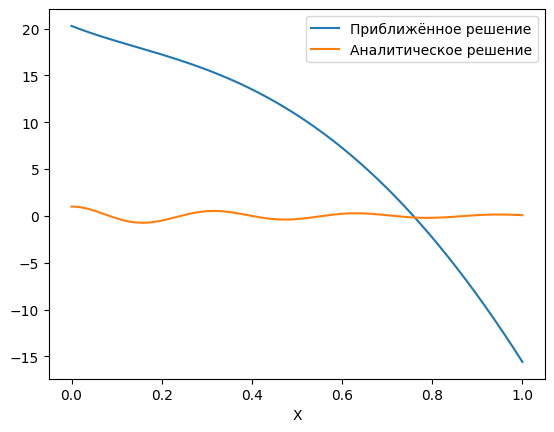

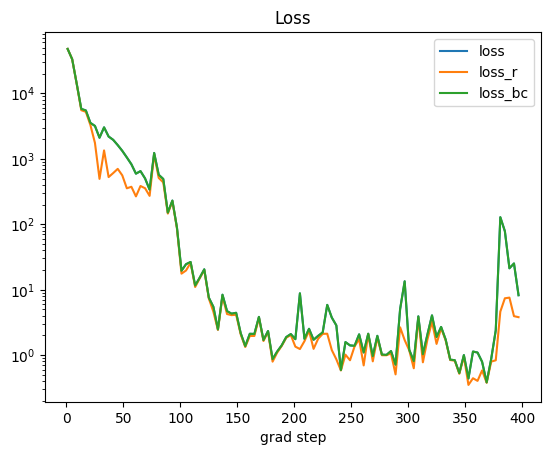

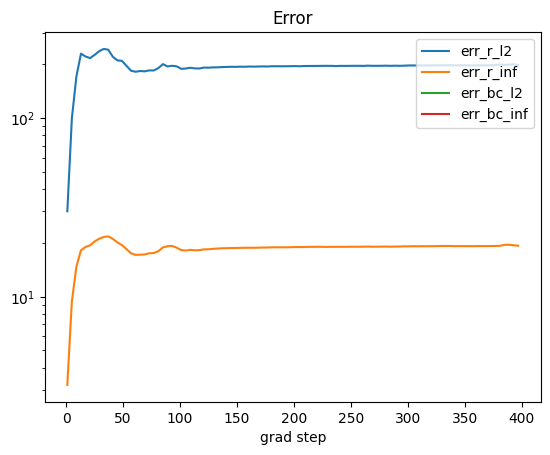

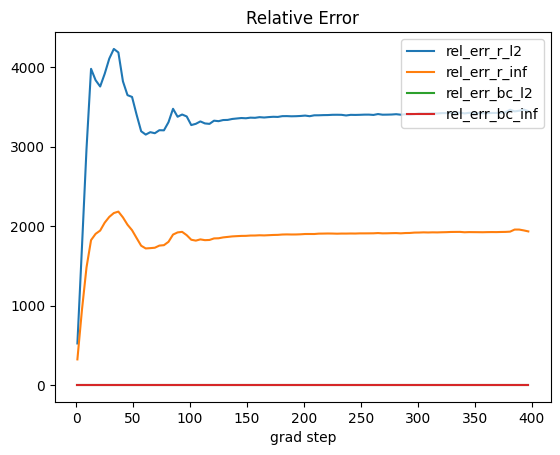

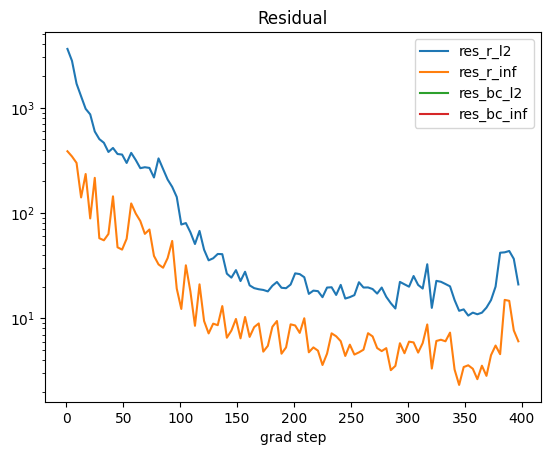

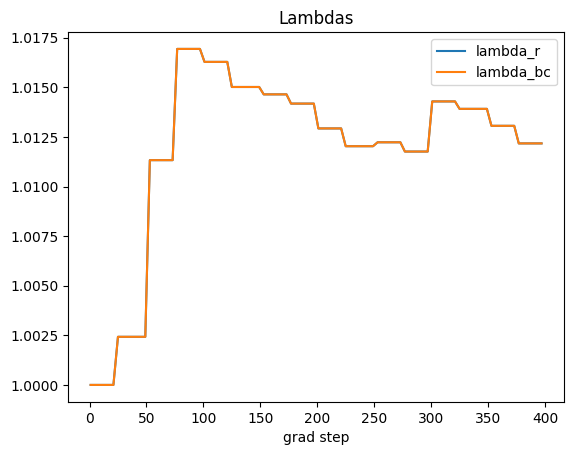

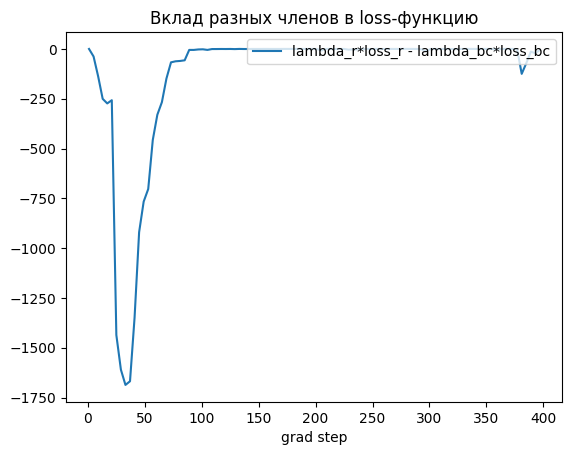

In [48]:
domain =  my_bvp.temporal_domain
u_exact = my_bvp.u_exact
n_train_points = training_params.n_train_points
batch_size =     training_params.batch_size
n_grad_steps =   training_params.n_epochs * (n_train_points // batch_size)

model = model.to('cpu')

with torch.no_grad():
    # Полученное решение
    x = torch.linspace(domain[0], domain[1], 1000).reshape(-1, 1)
    u_approx = model(x)
    plt.plot(x, u_approx, label="Приближённое решение")
    plt.plot(x, u_exact(x), label="Аналитическое решение")
    plt.xlabel("X")
    plt.legend(loc='upper right')
    plt.show()

    id = np.arange(0, n_grad_steps, n_train_points // batch_size)
    grad_steps_array = np.arange(1, n_grad_steps + 1)

    # Loss
    plt.semilogy(grad_steps_array[id], tm.data['loss'][id], label="loss")
    plt.semilogy(grad_steps_array[id], tm.data['loss_r'][id], label="loss_r")
    plt.semilogy(grad_steps_array[id], tm.data['loss_bc'][id], label="loss_bc")
    plt.title("Loss")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    # Error
    plt.semilogy(grad_steps_array[id], tm.data['err_r_l2'][id], label="err_r_l2")
    plt.semilogy(grad_steps_array[id], tm.data['err_r_inf'][id], label="err_r_inf")
    plt.semilogy(grad_steps_array[id], tm.data['err_bc_l2'][id], label="err_bc_l2")
    plt.semilogy(grad_steps_array[id], tm.data['err_bc_inf'][id], label="err_bc_inf")
    plt.title("Error")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    # Relative error
    plt.plot(grad_steps_array[id], tm.data['rel_err_r_l2'][id], label="rel_err_r_l2")
    plt.plot(grad_steps_array[id], tm.data['rel_err_r_inf'][id], label="rel_err_r_inf")
    plt.plot(grad_steps_array[id], tm.data['rel_err_bc_l2'][id], label="rel_err_bc_l2")
    plt.plot(grad_steps_array[id], tm.data['rel_err_bc_inf'][id], label="rel_err_bc_inf")
    plt.title("Relative Error")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    # Residual
    plt.semilogy(grad_steps_array[id], tm.data['res_r_l2'][id], label="res_r_l2")
    plt.semilogy(grad_steps_array[id], tm.data['res_r_inf'][id], label="res_r_inf")
    plt.semilogy(grad_steps_array[id], tm.data['res_bc_l2'][id], label="res_bc_l2")
    plt.semilogy(grad_steps_array[id], tm.data['res_bc_inf'][id], label="res_bc_inf")
    plt.title("Residual")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    # Lambdas
    plt.plot(grad_steps_array[id], tm.data['lambda_r'][id], label="lambda_r")
    plt.plot(grad_steps_array[id], tm.data['lambda_bc'][id], label="lambda_bc")
    plt.title("Lambdas")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    plt.plot(grad_steps_array[id], tm.data['lambda_r'][id] * tm.data['loss_r'][id] - tm.data['lambda_bc'][id] * tm.data['loss_bc'][id], label="lambda_r*loss_r - lambda_bc*loss_bc")
    #plt.plot(grad_steps_array[id], tm['lambda_bc'][id] * tm['loss_bc'][id], label="lambda_bc*loss_bc")
    plt.title("Вклад разных членов в loss-функцию")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()